# Balancing Imbalanced Datasets in Geotechnical ML

This notebook demonstrates practical techniques for handling class imbalance using the `imbalanced-learn` library (imblearn).

We'll use a synthetic, geotechnical-like dataset (e.g., simplified CPT features) and optionally try the same techniques on provided raw data if suitable.

What you'll learn:
- Why class imbalance hurts model performance
- Undersampling: RandomUnderSampler
- Oversampling: RandomOverSampler and SMOTE
- How to apply these safely within a train/test workflow
- How the distributions and model metrics change after balancing

Tip: Run each cell as we go and try changing parameters to see the effect.

## Imports and setup

We'll import core libraries, set a random seed for reproducibility, and configure plotting.

In [1]:
# Standard libraries
from __future__ import annotations

from pathlib import Path

# Imbalanced-learn
import imblearn as _imbl
import matplotlib.pyplot as plt

# Numerics, data, plotting
import numpy as np
import pandas as pd
import seaborn as sns

# ML
import sklearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plot style
sns.set_theme(style="whitegrid", context="notebook")
RANDOM_STATE = 42
FIGSIZE = (6, 4)
DATA_DIR = Path("data/raw")
print("Versions:")
print("  pandas    ", pd.__version__)
print("  sklearn   ", sklearn.__version__)
print("  imblearn  ", _imbl.__version__)
print("  seaborn   ", sns.__version__)

Versions:
  pandas     2.3.2
  sklearn    1.7.2
  imblearn   0.14.0
  seaborn    0.13.2


## Helper functions

- `plot_class_counts`: Visualize class distribution.
- `make_geotech_like_dataset`: Create an imbalanced synthetic dataset with CPT-inspired features.
- `evaluate_model`: Fit, predict, print metrics, and show confusion matrix.

In [40]:
def plot_class_counts(y, title="Class distribution"):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.countplot(x=y, ax=ax, palette="viridis")
    ax.set_title(title)
    ax.bar_label(ax.containers[0])
    plt.show()


def make_geotech_like_dataset(n_major=980, n_minor=20, random_state=RANDOM_STATE):
    rng = np.random.default_rng(random_state)
    # Make classes more overlapping and imbalance more extreme (~98:2)
    # Class 0 (majority):
    qc0 = rng.normal(loc=8.0, scale=3.5, size=n_major)
    fs0 = rng.normal(loc=0.12, scale=0.06, size=n_major)
    z0 = rng.uniform(1, 20, size=n_major)
    # Class 1 (minority):
    qc1 = rng.normal(loc=6.5, scale=2.5, size=n_minor)
    fs1 = rng.normal(loc=0.09, scale=0.05, size=n_minor)
    z1 = rng.uniform(1, 20, size=n_minor)

    qc = np.concatenate([qc0, qc1])
    fs = np.concatenate([fs0, fs1])
    z = np.concatenate([z0, z1])
    qc_clip = np.clip(qc, 0.1, None)
    Fr = (fs / qc_clip) * 100.0
    y = np.array([0] * n_major + [1] * n_minor)
    X = pd.DataFrame({"qc": qc, "fs": fs, "depth": z, "Fr": Fr})
    return X, pd.Series(y, name="target")


def evaluate_model(
    model, X_train, y_train, X_test, y_test, title="Model", normalize=None
):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {title} ===")
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=FIGSIZE)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    # Disable seaborn's grid on this axis to avoid extra boxes overlaying the 2x2 matrix
    ax.grid(False)
    ax.set_title(f"Confusion Matrix: {title}")
    plt.show()

## Create an imbalanced geotechnical-like dataset

We'll construct a dataset with a 95:5 class split. Features mimic simplified CPT measurements: `qc`, `fs`, `depth`, and `Fr`.

In [25]:
X, y = make_geotech_like_dataset(n_major=950, n_minor=50, random_state=RANDOM_STATE)
X.head()

,qc,fs,depth,Fr
0,9.066510,0.016592,18.588047,0.183005
1,4.360056,0.147106,4.825618,3.373950
2,10.626579,0.148652,18.661885,1.398867
3,11.291977,0.050254,1.339358,0.445044
4,1.171377,0.077274,18.574287,6.596842


C:\Users\TFH\AppData\Local\Temp\ipykernel_24580\2201693138.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=ax, palette="viridis")


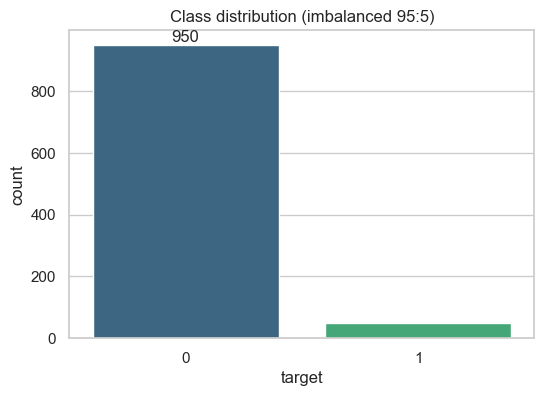

In [26]:
plot_class_counts(y, title="Class distribution (imbalanced 95:5)")

## Baseline model on imbalanced data

We'll train a simple pipeline: `StandardScaler` + `LogisticRegression`. Note: We split data before any rebalancing and only apply sampling to the training set.

=== Baseline (imbalanced) ===
              precision    recall  f1-score   support

           0      0.952     1.000     0.975       238
           1      0.000     0.000     0.000        12

    accuracy                          0.952       250
   macro avg      0.476     0.500     0.488       250
weighted avg      0.906     0.952     0.929       250



c:\Users\TFH\git_projects\course-machine-learning-for-geotechnics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\TFH\git_projects\course-machine-learning-for-geotechnics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\TFH\git_projects\course-machine-learning-for-geotechnics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

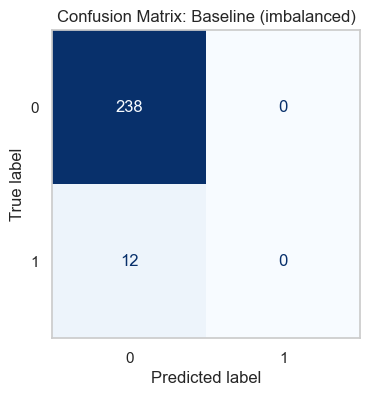

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
baseline = ImbPipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=RANDOM_STATE)),
    ]
)
evaluate_model(
    baseline, X_train, y_train, X_test, y_test, title="Baseline (imbalanced)"
)

## Undersampling with RandomUnderSampler

We downsample the majority class in the training set to balance with the minority. This can help models pay attention to the minority class, but you lose information from discarded samples.

=== RandomUnderSampler (balanced weights, 0.5 ratio) ===
              precision    recall  f1-score   support

           0      0.987     0.651     0.785       238
           1      0.108     0.833     0.190        12

    accuracy                          0.660       250
   macro avg      0.547     0.742     0.488       250
weighted avg      0.945     0.660     0.756       250



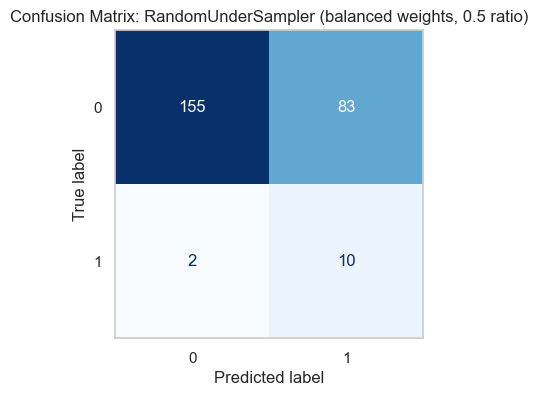

C:\Users\TFH\AppData\Local\Temp\ipykernel_24580\2201693138.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=ax, palette="viridis")


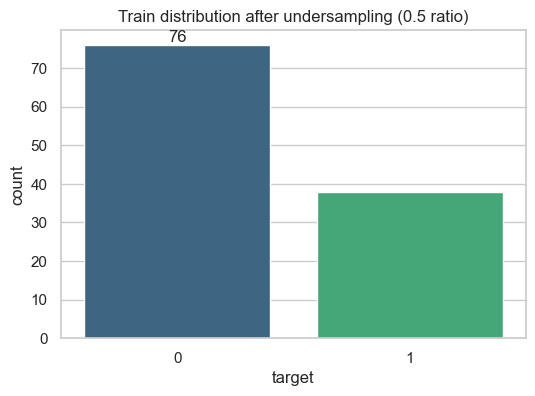

In [28]:
undersample = ImbPipeline(
    steps=[
        ("scaler", StandardScaler()),
        # Use a less aggressive undersampling ratio to retain more majority information
        ("under", RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=0.5)),
        # Help the classifier pay more attention to the minority class
        (
            "clf",
            LogisticRegression(
                random_state=RANDOM_STATE, class_weight="balanced", max_iter=1000
            ),
        ),
    ]
)
evaluate_model(
    undersample,
    X_train,
    y_train,
    X_test,
    y_test,
    title="RandomUnderSampler (balanced weights, 0.5 ratio)",
)
# Inspect class distribution after undersampling (train set only)
X_u, y_u = RandomUnderSampler(
    random_state=RANDOM_STATE, sampling_strategy=0.5
).fit_resample(X_train, y_train)
plot_class_counts(y_u, title="Train distribution after undersampling (0.5 ratio)")

## Oversampling with RandomOverSampler

We duplicate samples from the minority class in the training set. It preserves all majority data but may risk overfitting if duplicates are too frequent.

=== RandomOverSampler (balanced weights) ===
              precision    recall  f1-score   support

           0      0.987     0.643     0.779       238
           1      0.105     0.833     0.187        12

    accuracy                          0.652       250
   macro avg      0.546     0.738     0.483       250
weighted avg      0.945     0.652     0.750       250



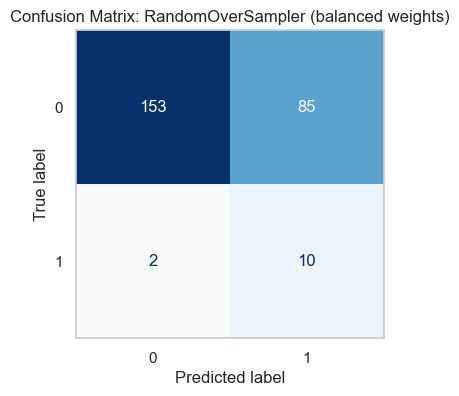

C:\Users\TFH\AppData\Local\Temp\ipykernel_24580\2201693138.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=ax, palette="viridis")


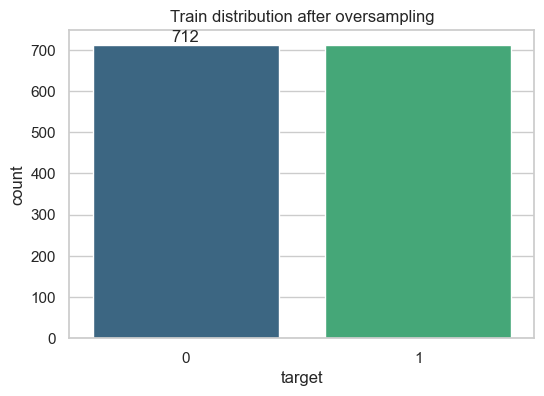

In [29]:
oversample = ImbPipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("over", RandomOverSampler(random_state=RANDOM_STATE)),
        (
            "clf",
            LogisticRegression(
                random_state=RANDOM_STATE, class_weight="balanced", max_iter=1000
            ),
        ),
    ]
)
evaluate_model(
    oversample,
    X_train,
    y_train,
    X_test,
    y_test,
    title="RandomOverSampler (balanced weights)",
)
# Inspect class distribution after oversampling (train set only)
X_o, y_o = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
plot_class_counts(y_o, title="Train distribution after oversampling")

## Oversampling with SMOTE

SMOTE generates synthetic samples for the minority class by interpolating between nearest neighbors. Often performs better than random oversampling.

We still only apply sampling to the training set to avoid leakage.

=== SMOTE (k=3, balanced weights) ===
              precision    recall  f1-score   support

           0      0.988     0.664     0.794       238
           1      0.111     0.833     0.196        12

    accuracy                          0.672       250
   macro avg      0.549     0.749     0.495       250
weighted avg      0.945     0.672     0.765       250



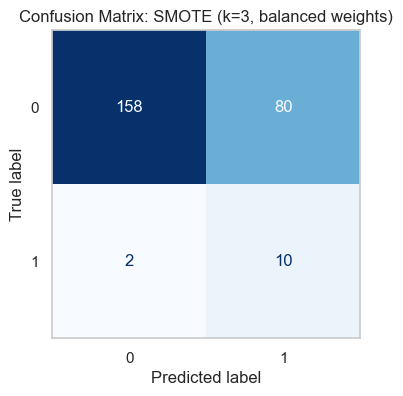

C:\Users\TFH\AppData\Local\Temp\ipykernel_24580\2201693138.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=ax, palette="viridis")


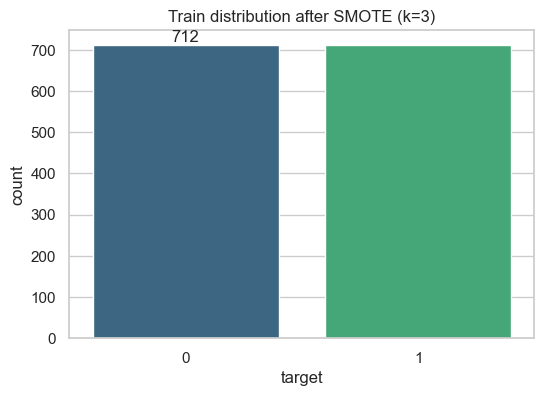

In [30]:
smote = ImbPipeline(
    steps=[
        ("scaler", StandardScaler()),
        # Lower k_neighbors to handle very small minority classes safely
        ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=3)),
        (
            "clf",
            LogisticRegression(
                random_state=RANDOM_STATE, class_weight="balanced", max_iter=1000
            ),
        ),
    ]
)
evaluate_model(
    smote, X_train, y_train, X_test, y_test, title="SMOTE (k=3, balanced weights)"
)
# Inspect class distribution after SMOTE (train set only)
X_s, y_s = SMOTE(random_state=RANDOM_STATE, k_neighbors=3).fit_resample(
    X_train, y_train
)
plot_class_counts(y_s, title="Train distribution after SMOTE (k=3)")

## Optional: Try with provided raw data (best effort)

We'll attempt to load `data/raw/CPT_PremstallerGeotechnik_revised.csv` (CPT) or `data/raw/earthquake_data.csv` (earthquakes) and create a simple binary label for demonstration.

Notes:
- Column names may vary; this block is resilient but may skip if required columns are missing.
- For CPT, we'll try to use `qc` and `fs` (or similarly named columns) and build a toy label via an Fr threshold.
- For earthquakes, we'll try `magnitude`/`mag` and `depth` to define a toy label like `mag >= 5.0`.

In [31]:
from pathlib import Path

import pandas as pd

# Paths
DATA_DIR = Path("..") / "data" / "model_ready"
CSV = DATA_DIR / "cpt_dataset_total.csv"

# Features and label
FEATURES = [
    "Depth (m)",
    "qc (MPa)",
    "fs (kPa)",
    "Rf (%)",
    "σ,v (kPa)",
    "u0 (kPa)",
    "σ',v (kPa)",
    "Qtn (-)",
    "Fr (%)",
]
LABEL = "Oberhollenzer_classes"

# Load dataset and split into features/label
df = pd.read_csv(CSV)
X = df[FEATURES].copy()
y = df[LABEL].copy()

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"X: {X.shape} | y: {y.shape}")
X.head(3)

Dataset loaded: 807293 rows, 13 columns
X: (807293, 9) | y: (807293,)


,Depth (m),qc (MPa),fs (kPa),Rf (%),"σ,v (kPa)",u0 (kPa),"σ',v (kPa)",Qtn (-),Fr (%)
0,0.39,0.06,0.01,0.01,7.41,3.83,3.58,23.33,0.01
1,0.40,0.22,0.01,0.01,7.60,3.92,3.68,13.40,0.01
2,0.41,0.05,0.01,0.01,7.79,4.02,3.77,12.04,0.01


In [41]:
def find_similar_column(cols, candidates):
    cols_lower = {c.lower(): c for c in cols}
    for name in candidates:
        if name in cols_lower:
            return cols_lower[name]
    # fuzzy contains check
    for c in cols:
        cl = c.lower()
        if any(name in cl for name in candidates):
            return c
    return None


def try_cpt_demo():
    """
    Load curated CPT train/test splits from data/model_ready and return Xtr, Xte, ytr, yte.
    """
    DATA_DIR = Path("..") / "data" / "model_ready"
    TRAIN_CSV = DATA_DIR / "cpt_dataset_train.csv"
    TEST_CSV = DATA_DIR / "cpt_dataset_test.csv"

    FEATURES = [
        "Depth (m)",
        "qc (MPa)",
        "fs (kPa)",
        "Rf (%)",
        "σ,v (kPa)",
        "u0 (kPa)",
        "σ',v (kPa)",
        "Qtn (-)",
        "Fr (%)",
    ]
    LABEL = "Oberhollenzer_classes"

    df_train = pd.read_csv(TRAIN_CSV)
    df_test = pd.read_csv(TEST_CSV)

    Xtr = df_train[FEATURES].copy()
    ytr = df_train[LABEL].copy()
    Xte = df_test[FEATURES].copy()
    yte = df_test[LABEL].copy()
    return Xtr, Xte, ytr, yte


def try_earthquake_demo():
    """
    Load earthquake_data.csv from data/raw, use multiple numeric features, and classify tsunami vs not-tsunami.
    Returns a stratified train/test split: Xtr, Xte, ytr, yte.
    """
    RAW_DIR = Path("..") / "data" / "raw"
    EQ_CSV = RAW_DIR / "earthquake_data.csv"

    df = pd.read_csv(EQ_CSV)

    # Label: 'tsunami' (binary)
    label_col = find_similar_column(df.columns, ["tsunami"])
    if label_col is None:
        raise ValueError(
            "Could not find 'tsunami' label column in earthquake_data.csv."
        )

    y_raw = df[label_col].copy()
    if y_raw.dtype == "O":
        # Map common truthy/falsey strings to binary
        y = (
            y_raw.astype(str)
            .str.strip()
            .str.lower()
            .map(
                {
                    "1": 1,
                    "yes": 1,
                    "y": 1,
                    "true": 1,
                    "t": 1,
                    "0": 0,
                    "no": 0,
                    "n": 0,
                    "false": 0,
                    "f": 0,
                }
            )
            .fillna(0)
            .astype(int)
        )
    else:
        y = (pd.to_numeric(y_raw, errors="coerce").fillna(0) > 0).astype(int)

    # Preferred numeric feature candidates (use those that exist)
    preferred_candidates = [
        "mag",
        "magnitude",
        "depth",
        "latitude",
        "longitude",
        "gap",
        "dmin",
        "rms",
        "horizontalerror",
        "deptherror",
        "magerror",
        "magnst",
        "nst",
        "sig",
    ]

    feature_cols = []
    for cand in preferred_candidates:
        col = find_similar_column(df.columns, [cand])
        if col and col not in feature_cols and col != label_col:
            feature_cols.append(col)

    # Add any remaining numeric columns (excluding the label) to enrich features
    numeric_cols = [
        c for c in df.select_dtypes(include=["number"]).columns if c != label_col
    ]
    for c in numeric_cols:
        if c not in feature_cols:
            feature_cols.append(c)

    # Build feature matrix and clean
    X = df[feature_cols].copy()
    X = X.apply(pd.to_numeric, errors="coerce")

    # Drop rows with missing features or labels
    valid_mask = X.notna().all(axis=1) & y.notna()
    X = X[valid_mask]
    y = y[valid_mask]

    # If only one class present, do a non-stratified split to avoid errors
    stratify_arg = y if y.nunique() > 1 else None

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=stratify_arg
    )
    return Xtr, Xte, ytr, yte

In [42]:
# Xtr, Xte, ytr, yte = try_cpt_demo()
Xtr, Xte, ytr, yte = try_earthquake_demo()
print(f"Train: X={Xtr.shape}, y={ytr.shape} | Test: X={Xte.shape}, y={yte.shape}")

Train: X=(586, 10), y=(586,) | Test: X=(196, 10), y=(196,)


Using dataset: CPT train/test splits (model_ready)


C:\Users\TFH\AppData\Local\Temp\ipykernel_24580\1898074633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=ax, palette="viridis")


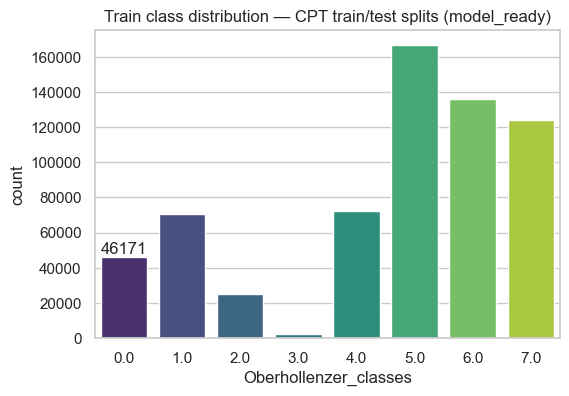

c:\Users\TFH\git_projects\course-machine-learning-for-geotechnics\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== SMOTE on CPT train/test splits (model_ready) ===
              precision    recall  f1-score   support

         0.0      0.213     0.173     0.191     14308
         1.0      0.345     0.465     0.396     19344
         2.0      0.253     0.495     0.335      9061
         3.0      0.110     0.560     0.184      1995
         4.0      0.392     0.246     0.302     22226
         5.0      0.517     0.575     0.544     35756
         6.0      0.405     0.097     0.157     32343
         7.0      0.514     0.654     0.576     29542

    accuracy                          0.398    164575
   macro avg      0.344     0.408     0.336    164575
weighted avg      0.412     0.398     0.377    164575



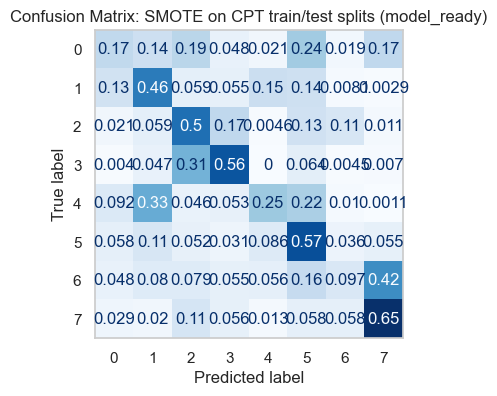

In [47]:
# Use curated CPT train/test splits by default
Xtr, Xte, ytr, yte = try_cpt_demo()
raw_name = "CPT train/test splits (model_ready)"
# Xtr, Xte, ytr, yte = try_earthquake_demo()
# raw_name = "Earthquake data (raw)"

print(f"Using dataset: {raw_name}")
plot_class_counts(ytr, title=f"Train class distribution — {raw_name}")

pipe = ImbPipeline(
    [
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", LogisticRegression(random_state=RANDOM_STATE)),
    ]
)

evaluate_model(pipe, Xtr, ytr, Xte, yte, title=f"SMOTE on {raw_name}", normalize="true")

## Key takeaways

- Always split into train/test before applying any sampling — sample the training set only.
- Undersampling is fast and simple but throws away majority data.
- Random oversampling balances classes but may overfit — SMOTE is often better.
- Evaluate with metrics that reflect minority performance (e.g., recall, F1, confusion matrix).

Next: try different classifiers (e.g., RandomForest) or combine with class weights.